In [2]:
import pandas as pd

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [5]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
     

In [7]:

!pip install -q findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from google.colab import files
files.upload()

df = spark.read.csv('BostonHousing.csv',inferSchema=True, header=True)

from pyspark.ml.feature import VectorAssembler

df.columns

Saving BostonHousing.csv to BostonHousing (1).csv


['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat',
 'medv']

In [8]:

inputCols = [
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat'
]

only_features= ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']
assembler= VectorAssembler(inputCols=only_features,outputCol='features')

In [9]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feat_df=assembler.transform(df).select('features')

In [10]:
scaler= StandardScaler(inputCol='features',outputCol='scaledFeature',withMean=True,withStd=True).fit(feat_df)
df_scaled=scaler.transform(feat_df)
df_scaled.show(5)

n_components=2
pca=PCA(k=n_components,inputCol='scaledFeature',outputCol='pcafeatures').fit(df_scaled)

df_pca=pca.transform(df_scaled)
print('explained variance Ratio',pca.explainedVariance.toArray())
df_pca.show(5)

X_pca=df_pca.rdd.map(lambda row:row.pcafeatures).collect()
X_pca=np.array(X_pca)

X_pca

+--------------------+--------------------+
|            features|       scaledFeature|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
+--------------------+--------------------+
only showing top 5 rows

explained variance Ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|       scaledFeature|         pcafeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
+---------

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



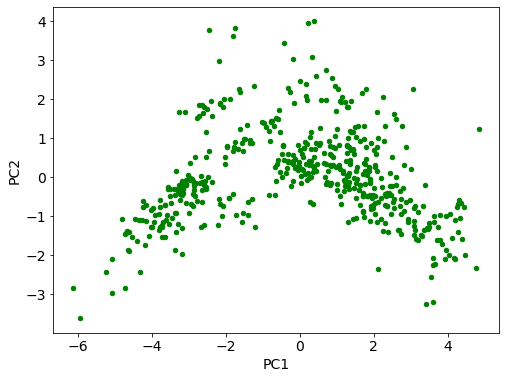

In [11]:
df_pca=pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()

plt.rcParams['figure.figsize']=8,6
plt.rcParams['font.size']=14
ax1=df_pca.plot.scatter(x='PC1',y='PC2',c='green')

output=assembler.transform(df)
f_data=output.select('features','medv')
f_data.show(5)

In [12]:
train_data,test_data= f_data.randomSplit([0.90,0.1])

     

regressor=LinearRegression(featuresCol='features',labelCol='medv')
regressor=regressor.fit(train_data)
     

coeff=regressor.coefficients
intr=regressor.intercept
print("Coefficient:", coeff)
print("Intercept:", intr)

print("Coefficient: %a" %coeff)
print("Intercept: %f" %intr)

Coefficient: [-0.10351796515117316,0.04036149170123111,0.017619760679349932,2.085145424394282,-17.30919539218479,3.655937928840547,0.0008468776657597206,-1.3830122596905052,0.2894914767797134,-0.011692277109099763,-0.9755798770255252,0.00957372804156805,-0.523112140153559]
Intercept: 37.05651306576981
Coefficient: DenseVector([-0.1035, 0.0404, 0.0176, 2.0851, -17.3092, 3.6559, 0.0008, -1.383, 0.2895, -0.0117, -0.9756, 0.0096, -0.5231])
Intercept: 37.056513


In [13]:

pred = regressor.evaluate(test_data)
pred.predictions.show(5)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01538,90.0,3.7...|44.0|37.026800996439526|
|[0.01965,80.0,1.7...|20.1|20.105708197462935|
|[0.02763,75.0,2.9...|30.8|30.980710895037674|
|[0.02985,0.0,2.18...|28.7| 25.41474698118386|
|[0.0351,95.0,2.68...|48.5|41.357209489921885|
+--------------------+----+------------------+
only showing top 5 rows



In [14]:
from pyspark.ml.evaluation import RegressionEvaluator
eval=RegressionEvaluator(labelCol='medv',predictionCol='prediction',metricName='rmse')
     

rmse=eval.evaluate(pred.predictions)
print("Root Mean Square Error (RMSE) : %.3f" %rmse)

mse=eval.evaluate(pred.predictions,{eval.metricName:"mse"})
print("Mean Squared Error (MSE) : %.3f" %mse)

mae=eval.evaluate(pred.predictions,{eval.metricName:"mae"})
print("Mean Absolute Error (MAER) : %.3f" % mae)

r2=eval.evaluate(pred.predictions,{eval.metricName:"r2"})
print("r2 : %.3f" %r2)

Root Mean Square Error (RMSE) : 4.812
Mean Squared Error (MSE) : 23.154
Mean Absolute Error (MAER) : 2.882
r2 : 0.803
